In [1]:
%matplotlib inline

In [34]:
import  os
import  sys
import  glob
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  healpy 
import  requests
import  pandas                      as      pd
import  pylab                       as      pl
import  numpy                       as      np
import  matplotlib.pyplot           as      plt
import  astropy.io.fits             as      fits
import  skyfactor_v2
import  skyfactor_v3

from    astropy.table               import  Table, join, vstack, unique
from    astropy.coordinates         import  SkyCoord
from    astropy                     import  units as u
from    desitarget.cmx              import  cmx_targetmask
from    desitarget.targets          import  desi_mask, bgs_mask, mws_mask
from    desispec.interpolation      import  resample_flux
from    desispec.resolution         import  Resolution
from    desispec.specscore          import  compute_frame_scores
from    collections                 import  OrderedDict
from    mpl_toolkits.axes_grid1     import  make_axes_locatable
from    itertools                   import  combinations
from    desisurvey.utils            import  get_date
from    PIL                         import  Image
from    io                          import  BytesIO
from    desitarget.sv1              import  sv1_cuts 
from    desiutil                    import  dust

In [12]:
from    desisurvey.etc              import  seeing_exposure_factor, transparency_exposure_factor, dust_exposure_factor, airmass_exposure_factor

In [13]:
# from    skyfactor_v2.moonmodel_7160 import moonmodel as moonmodel_7160
# from    skyfactor_v3.moonmodel_4000 import moonmodel as moonmodel_4000

In [26]:
def  exposure_time(nominal=150., seeing=1.1, transparency=1.0, EBV=0.0, airmass=1.0, moon_frac=0.5, moon_sep=40., moon_alt=30., arm='b'):
    # Calculate actual / nominal factors.
    f_seeing       = seeing_exposure_factor(seeing)
    f_transparency = transparency_exposure_factor(transparency)
    f_dust         = dust_exposure_factor(EBV)
    f_airmass      = airmass_exposure_factor(airmass)

    if arm == 'b':
      f_moon       = moonmodel_4000(moon_sep, moon_alt, moon_frac, airmass)

    else:
      assert  arm == 'z'
        
      f_moon       = moonmodel_7160(moon_sep, moon_alt, moon_frac, airmass) 
    
    # Calculate the exposure time required at the specified condtions.
    actual_time    = nominal * f_seeing * f_transparency * f_dust * f_airmass * f_moon 

    return  actual_time

In [35]:
def get_cframelist(version='v2'):
  cpath      = '/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_{}.fits'.format(version)
  cframes    = Table(fits.open(cpath)[1].data)

  del  cframes['cframe']

  cols       = list(cframes.columns)

  for x in cols:
    cframes.rename_column(x, x.upper())

  # new      = mean.columns
  # keep     = [x not in cframes.columns for x in new]  
  
  # new      = ['EXPID'] + [x for i, x in enumerate(new) if keep[i]]
  # cframes  = join(cframes, mean[new], keys='EXPID', join_type='left')

  keep       = (cframes['CAMERA'] == 'b') & (cframes['PETAL_LOC'] == 0) 
  cframes    =  cframes[keep]

  uids, cnts =  np.unique(cframes['EXPID'], return_counts=True)

  assert  cnts.max() == 1

  cframes.sort('MJD')
  
  return  cframes

In [97]:
def get_gfa(gold=False):
    gfa = Table(fits.open('/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes_v2_gfa.fits')[1].data)
    
    if gold:
        gfa = gfa[gfa['N_SOURCES_FOR_PSF'] > 2]
        
    
    return  gfa  

In [105]:
gfa = get_gfa()
gfa

MEDIAN,MEAN,N_NON_FINITE,MAX,MIN,SIG_ROBUST,SIG,MEDIAN_Q1,MEAN_Q1,N_NON_FINITE_Q1,MAX_Q1,MIN_Q1,SIG_ROBUST_Q1,SIG_Q1,MEDIAN_Q2,MEAN_Q2,N_NON_FINITE_Q2,MAX_Q2,MIN_Q2,SIG_ROBUST_Q2,SIG_Q2,MEDIAN_Q3,MEAN_Q3,N_NON_FINITE_Q3,MAX_Q3,MIN_Q3,SIG_ROBUST_Q3,SIG_Q3,MEDIAN_Q4,MEAN_Q4,N_NON_FINITE_Q4,MAX_Q4,MIN_Q4,SIG_ROBUST_Q4,SIG_Q4,SKY_MAG_AB,SKY_MAG_AB_PER_AMP,PETAL_LOC,EXPID,MJD,SKYRA,SKYDEC,MOONRA,MOONDEC,T_C_FOR_DARK,T_C_FOR_DARK_IS_GUESS,TIME_S_FOR_DARK,AIRMASS,NIGHT,EXPTIME,CUBE_INDEX,RACEN,DECCEN,CONTRAST,FIBER_FRACFLUX,N_SOURCES_FOR_PSF,APER_CORR_FAC,XCENTROID_PSF,YCENTROID_PSF,MOON_SEP_DEG,ZP_ADU_PER_S,TRANSPARENCY,NPIX_BAD_TOTAL,NPIX_BAD_PER_AMP,OVERSCAN_MEDIANS_ADU,PRESCAN_MEDIANS_ADU,FWHM_MAJOR_PIX,FWHM_MINOR_PIX,FWHM_PIX,FWHM_ASEC,N_SOURCES,NAXIS,CD,CDELT,CRPIX,CRVAL,LONGPOLE,LATPOLE,PV2,DO_FIT_DARK_SCALING,MASTER_DARK_EXPTIME,MASTER_DARK_GCCDTEMP,DARK_TEMP_SCALING_FACTOR,TOTAL_DARK_SCALING_FACTOR,DARK_RESCALE_FACTORS_PER_AMP,DARK_RESCALE_FACTOR_BESTFIT,DARK_RESCALE_FACTOR_ADOPTED,APPLY_DARK_RESCALE_FACTOR,DARK_RESCALE_NCALLS,DARK_RESCALE_CONVERGED
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1498.5,1498.71237064332,0.0,14171.5,1305.5,74.1301109252801,74.1301109252801,1510.5,1512.1791519046753,0.0,6803.5,1436.0,10.378215529539215,10.378215529539215,1448.0,1453.5707260250122,0.0,13751.0,1386.0,10.378215529539215,10.378215529539215,1506.5,1508.7537964813469,0.0,7934.5,1429.0,12.602118857297617,12.602118857297617,1377.0,1381.3672603636749,0.0,7951.5,1305.5,11.119516638792016,11.119516638792016,21.166722602992905,21.162157,4.0,52090,58905.26207281,180.012,-0.510261,6.887381,-2.523766,9.646,0.0,5.0,1.663456,20200225,5.0,62.0,179.99966051964955,-0.5499658695163923,3.8426876448623024,0.15819694491469147,4.0,0.4802858062435611,24.880265561743073,24.893638934214035,172.3655579744284,25.4973871698881,0.9372713127978513,0.0,0.0,1407.0,1394.0,12.65485591453827,11.17607840033076,11.847539901733398,2.4287456798553464,11.0,1540.0,2.0343276314399996e-08,1.0,16266.06196518,89.7508695,180.0,90.0,0.0,1.0,5.0,10.07,0.887832033298626,4.692542112685003,1.0497448730468755,1.050003051757813,1.050003051757813,1.0,36.0,1.0
1499.0,1499.251294276511,0.0,15046.0,1307.0,73.3888098160273,73.3888098160273,1511.0,1512.3986986736918,0.0,6854.5,1438.0,10.378215529539215,10.378215529539215,1448.5,1453.66285125969,0.0,14277.5,1389.0,11.860817748044816,11.860817748044816,1508.0,1510.5980640973232,0.0,8373.5,1431.0,12.602118857297617,12.602118857297617,1378.0,1382.3064977364947,0.0,9094.5,1307.0,11.860817748044816,11.860817748044816,21.217548248841762,21.204947,4.0,52112,58905.30090941,180.006929,-0.50838,7.309801,-2.342021,9.961,0.0,5.0,1.376164,20200225,5.0,62.0,179.99977687306293,-0.5499355763099012,3.826443526244743,0.14701758557538996,4.0,0.45953399779281806,24.847845875837045,24.892968302206743,172.10083750631094,25.510688711259093,0.9230030955152957,0.0,0.0,1406.0,1393.0,13.247016338374248,11.17556540908111,12.196193218231201,2.500219609737396,13.0,1540.0,2.0343276314399996e-08,1.0,15897.311208911568,89.74927450000001,180.0,90.0,0.0,1.0,5.0,10.093,0.969903410767198,4.838813956923457,1.0088212585449217,1.0060714721679689,1.0060714721679689,1.0,33.0,1.0
1498.5,1498.793664976608,0.0,15371.5,1307.5,73.3888098160273,73.3888098160273,1510.5,1512.0164832773135,0.0,6996.5,1437.0,10.378215529539215,10.37821

In [106]:
# r band.
keep    = ['EXPID', 'MOONRA', 'MOONDEC', 'AIRMASS', 'FIBER_FRACFLUX', 'MOON_SEP_DEG', 'TRANSPARENCY', 'SKY_MAG_AB', 'FWHM_ASEC']

In [113]:
cframes = get_cframelist()

for x in ['MOON_RA', 'MOON_DEC', 'MOON_SEP', 'AIRMASS', 'LAT', 'LON', 'ELV', 'CAMERA', 'PROGRAM']:
    del cframes[x]

cframes = join(cframes, gfa[keep], keys='EXPID', join_type='left')
cframes

NIGHT,MJD,TILEID,EXPID,EXPTIME,PETAL_LOC,SPECGRPH,RA,DEC,MOON_ALT,MOON_FRAC,SUN_ALT,SUN_RA,SUN_DEC,SUN_SEP,EBV,MOONRA,MOONDEC,AIRMASS,FIBER_FRACFLUX,MOON_SEP_DEG,TRANSPARENCY,SKY_MAG_AB,FWHM_ASEC
str40,float64,int64,int64,float64,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,70502,52090,900.0,0,0,180.012,-0.510261,-34.718022305904064,0.0627905403740725,-58.985404389203396,338.8184557889157,-8.90282836156349,156.88472549965033,0.031056919357460633,6.887381,-2.523766,1.663456,0.15819694491469147,172.3655579744284,0.9372713127978513,21.166722602992905,2.4287456798553464
20200225,58905.29573492,70502,52112,900.0,0,0,180.006929,-0.50838,-44.78323495364497,0.06456711009394417,-65.64763237733636,338.8556693565404,-8.888320131591259,156.92963241839925,0.0312053262371375,7.309801,-2.342021,1.376164,0.14701758557538996,172.10083750631094,0.9230030955152957,21.217548248841762,2.500219609737396
20200225,58905.31193004,70502,52113,900.0,0,0,180.005321,-0.50784,-48.586919491100886,0.06531494808352112,-66.79677755424515,338.8711961359056,-8.882273781256869,156.94780316155754,0.031253747139170805,7.483259,-2.267338,1.304497,0.1323204773608042,171.9488044881412,0.9102086081517938,21.263907308525066,2.7339590740203854
20200225,58905.32773044,70502,52114,900.0,0,0,180.00393,-0.507439,-51.96852565860669,0.06604845305372314,-66.72988951170322,338.8863448289446,-8.876377467093185,156.96531649871432,0.03129685304110389,7.656684,-2.19264,1.253326,0.13466367435275842,171.79819092568044,0.9017370739741843,21.324630479899508,2.7561739110946655
20200225,58905.34240863,70502,52115,900.0,0,0,180.002758,-0.50717,-54.73305155535852,0.0667333011269644,-65.62130882827513,338.9004160743998,-8.870902290343162,156.9814314957455,0.03133440790266168,7.815007,-2.124421,1.219535,0.1281347929379673,171.67808843495237,0.8929825217020598,21.36790603552639,2.680836544036865
20200225,58905.35785641,70502,52116,900.0,0,0,180.00163,-0.506989,-57.14471621920915,0.06745762823660251,-63.508533242504264,338.91522163835987,-8.865142463156191,156.99824918477057,0.03137193973175106,7.980848,-2.052939,1.196954,0.1216169290927204,171.518018723355,0.8862149681177143,21.463676798912488,2.796740245819092
20200227,58907.38710085,70502,52447,500.0,0,0,179.999229,-0.50693,-44.5709697497139,0.19181133310720833,-56.96464169683635,340.8290572726072,-8.103346848212203,159.04038863424637,0.031457665975618346,30.088466,7.371094,1.188351,0.5857001808891155,149.1894459951971,0.1583978217647478,20.922357345211974,1.0591483545303344
20200227,58907.39358829,70502,52448,500.0,0,0,179.999229,-0.50693,-45.61385767370481,0.192293202118483,-55.430239699792985,340.83523698883977,-8.10090311045813,159.04697410482876,0.031457665975618346,30.088466,7.371094,1.188351,0.5999689516681834,149.2298332062412,0.07582041841670169,20.903188985562736,0.9876743268966675
20200228,58908.18319769,70500,52630,500.0,0,0,119.001779,50.00322,18.89320482922571,0.2543762544024462,-38.74253368941566,341.5746822133059,-7.802289556799742,124.95588876434323,0.050803485029043874,39.002114,10.866708,1.056503,0.5760015734679196,75.29000319072756,0.133863063143757,20.23260653308739,1.030655370950699


In [114]:
btimes    = []
ztimes    = []

for i, _ in enumerate(cframes):    
  btimes.append(exposure_time(150., _['FWHM_ASEC'], _['TRANSPARENCY'], _['EBV'], _['AIRMASS'], _['MOON_FRAC'], _['MOON_SEP_DEG'], _['MOON_ALT'], arm='b'))
  ztimes.append(exposure_time(150., _['FWHM_ASEC'], _['TRANSPARENCY'], _['EBV'], _['AIRMASS'], _['MOON_FRAC'], _['MOON_SEP_DEG'], _['MOON_ALT'], arm='z'))  

cframes['B_REQTIME_%'] = 100. * cframes['EXPTIME'] / btimes
cframes['Z_REQTIME_%'] = 100. * cframes['EXPTIME'] / ztimes
cframes

NIGHT,MJD,TILEID,EXPID,EXPTIME,PETAL_LOC,SPECGRPH,RA,DEC,MOON_ALT,MOON_FRAC,SUN_ALT,SUN_RA,SUN_DEC,SUN_SEP,EBV,MOONRA,MOONDEC,AIRMASS,FIBER_FRACFLUX,MOON_SEP_DEG,TRANSPARENCY,SKY_MAG_AB,FWHM_ASEC,B_REQTIME_%,Z_REQTIME_%
str40,float64,int64,int64,float64,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20200225,58905.25690431,70502,52090,900.0,0,0,180.012,-0.510261,-34.718022305904064,0.0627905403740725,-58.985404389203396,338.8184557889157,-8.90282836156349,156.88472549965033,0.031056919357460633,6.887381,-2.523766,1.663456,0.15819694491469147,172.3655579744284,0.9372713127978513,21.166722602992905,2.4287456798553464,45.32834762388894,45.32834762388894
20200225,58905.29573492,70502,52112,900.0,0,0,180.006929,-0.50838,-44.78323495364497,0.06456711009394417,-65.64763237733636,338.8556693565404,-8.888320131591259,156.92963241839925,0.0312053262371375,7.309801,-2.342021,1.376164,0.14701758557538996,172.10083750631094,0.9230030955152957,21.217548248841762,2.500219609737396,53.313650877743434,53.313650877743434
20200225,58905.31193004,70502,52113,900.0,0,0,180.005321,-0.50784,-48.586919491100886,0.06531494808352112,-66.79677755424515,338.8711961359056,-8.882273781256869,156.94780316155754,0.031253747139170805,7.483259,-2.267338,1.304497,0.1323204773608042,171.9488044881412,0.9102086081517938,21.263907308525066,2.7339590740203854,49.0582084071392,49.0582084071392
20200225,58905.32773044,70502,52114,900.0,0,0,180.00393,-0.507439,-51.96852565860669,0.06604845305372314,-66.72988951170322,338.8863448289446,-8.876377467093185,156.96531649871432,0.03129685304110389,7.656684,-2.19264,1.253326,0.13466367435275842,171.79819092568044,0.9017370739741843,21.324630479899508,2.7561739110946655,50.67365734381011,50.67365734381011
20200225,58905.34240863,70502,52115,900.0,0,0,180.002758,-0.50717,-54.73305155535852,0.0667333011269644,-65.62130882827513,338.9004160743998,-8.870902290343162,156.9814314957455,0.03133440790266168,7.815007,-2.124421,1.219535,0.1281347929379673,171.67808843495237,0.8929825217020598,21.36790603552639,2.680836544036865,53.53585323102669,53.53585323102669
20200225,58905.35785641,70502,52116,900.0,0,0,180.00163,-0.506989,-57.14471621920915,0.06745762823660251,-63.508533242504264,338.91522163835987,-8.865142463156191,156.99824918477057,0.03137193973175106,7.980848,-2.052939,1.196954,0.1216169290927204,171.518018723355,0.8862149681177143,21.463676798912488,2.796740245819092,52.082557564870804,52.082557564870804
20200227,58907.38710085,70502,52447,500.0,0,0,179.999229,-0.50693,-44.5709697497139,0.19181133310720833,-56.96464169683635,340.8290572726072,-8.103346848212203,159.04038863424637,0.031457665975618346,30.088466,7.371094,1.188351,0.5857001808891155,149.1894459951971,0.1583978217647478,20.922357345211974,1.0591483545303344,37.12438870739158,37.12438870739158
20200227,58907.39358829,70502,52448,500.0,0,0,179.999229,-0.50693,-45.61385767370481,0.192293202118483,-55.430239699792985,340.83523698883977,-8.10090311045813,159.04697410482876,0.031457665975618346,30.088466,7.371094,1.188351,0.5999689516681834,149.2298332062412,0.07582041841670169,20.903188985562736,0.9876743268966675,19.546807028144812,19.546807028144812
20200228,58908.18319769,70500,52630,500.0,0,0,119.001779,50.00322,18.89320482922571,0.2543762544024462,-38.74253368941566,341.5746822133059,-7.802289556799742,124.95588876434323,0.050803485029043874,39.002114,10.866708,1.056503,0.5760015734679196,75.29000319072756,0.133863063143757,20.23260653308739,1.030655370950699,23.929310756031317,26.34249463721794


In [5]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]

In [7]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0) + 0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    
    return  mag

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

In [8]:
# tile, night =  70500, '20200303'
tile, night   =  70502, '20200225'

root          = '/global/cfs/cdirs/desi/spectro/redux/minisv2/tiles/{}/{}/'.format(tile, night)

##  Truth table 

There are some caveats as Prospect behaviour changed midway, 
and it’s making it hard to combine everything in a sensible way. 

I only noticed this yesterday. If you follow these rules, you should 
end up with a reasonable truth table:
 
* Vi_combined_flag > 2.5
* Vi_diff < 2

If “VI z” and “Redrock z” differ by more than 0.01, take the “VI z” provided 
the above conditions are met.  If “VI spectype” and “Redrock spectype” differ, 
take the “VI spectype provided the above conditions are met.
 
More caveats:
* These are on the old reductions – many borderline cases will be resolved with the new reductions.
* In some instances, the inspector’s spectral classification was lost. It’s possible some objects with the wrong spec class slipped through – but they will be a handful, I think.
* The VI_combined_flag is a simple arithmetic mean between all VIs for a given object. There were 3 people providing VIs for this tile. There will be better ways to combine flags, this is just a first go. VI_diff is the maximal difference between classifications in a given object.

In [9]:
truth         = pd.read_csv('/global/homes/m/mjwilson/BGS/MINISV/truth_table_BGS_70502_v0.2.txt')
truth         = Table(np.array(truth), names=truth.columns)

truth['VI z'] = [x.replace('\n', '').strip() for x in truth['VI z']]

_             = [x != '--'   for x in truth['VI z']]  
truth         = truth[_]

truth['VI z'] = [np.float(x) for x in truth['VI z']]

In [10]:
for x in truth.columns:
    print(x)

TargetID
Redrock spectype
Redrock z
VI z
VI spectype
vi_combined_flag
vi_diff
VI issue


In [11]:
truth = truth[(truth['vi_combined_flag'] > 2.5) & (truth['vi_diff'] < 2.0)]
truth.sort('vi_combined_flag')
truth

TargetID,Redrock spectype,Redrock z,VI z,VI spectype,vi_combined_flag,vi_diff,VI issue
object,object,object,float64,object,object,object,object
35185730586152802,GALAXY,0.541,0.5415,GALAXY,3.0,0,--
35185724546353053,GALAXY,0.326,0.3257,GALAXY,3.0,0,--
35185718489776718,GALAXY,0.311,0.3114,GALAXY,3.0,0,--
35185724550548779,GALAXY,0.221,0.2211,GALAXY,3.0,0,--
35185760772556026,GALAXY,0.094,0.0934,--,3.0,0,R
35185718489776458,GALAXY,0.484,0.484,GALAXY,3.0,0,--
35185724550549879,GALAXY,0.545,0.5449,GALAXY,3.0,0,--
35185718506553564,GALAXY,0.845,0.8452,GALAXY,3.0,0,--
35185760751583534,GALAXY,1.324,0.2845,--,3.0,0,R


Text(0,0.5,'rr redshift')

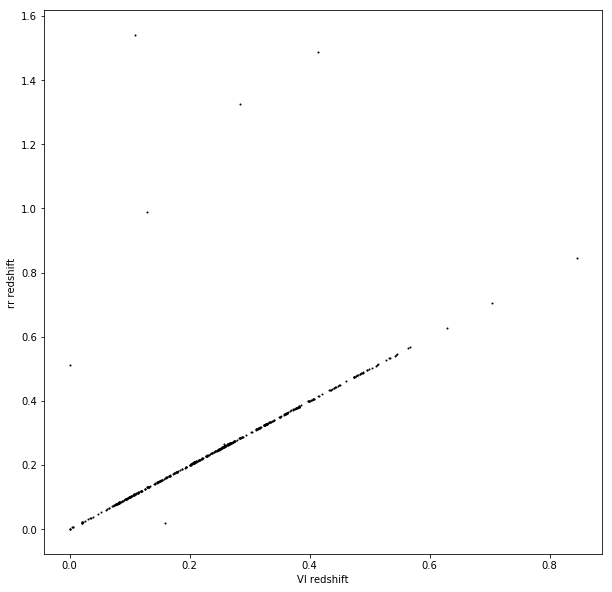

In [12]:
pl.plot(truth['VI z'], truth['Redrock z'], marker='.', lw=0.0, c='k', markersize=2)

pl.xlabel('VI redshift')
pl.ylabel('rr redshift')

Text(0.5,0,'VI z')

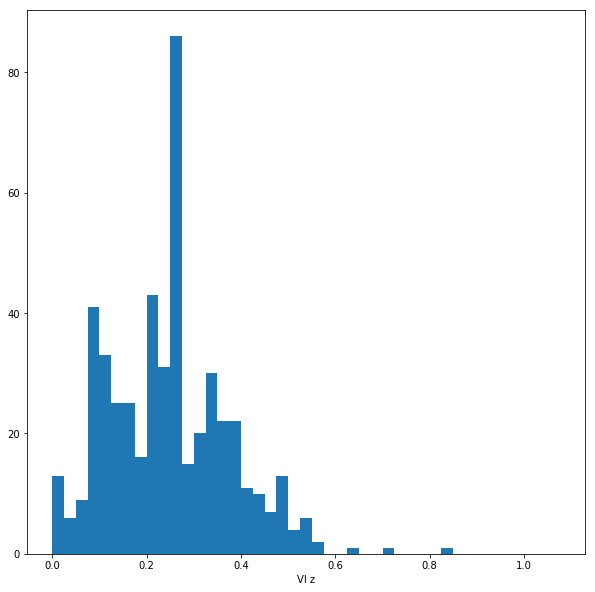

In [95]:
_ = pl.hist(truth['VI z'], bins=np.arange(0.0, 1.1, 0.025))
pl.xlabel('VI z')

In [ ]:
plot = False

for petal in [0,3,6,7,9]: 
    specfile                  = root + 'coadd-{}-{}-{}.fits'.format(petal, tile, night)
    coadds                    = Table(fits.open(specfile)[1].data)
    
    zbest                     = Table(fits.open(root + 'zbest-{}-{}-{}.fits'.format(petal, tile, night))[1].data)
    
    targetids                 = zbest['TARGETID']
    fibstatus                 = fitsio.read(specfile, ext=1)['FIBERSTATUS']
    
    spectra                   = desispec.io.read_spectra(specfile)
    spectra.fibermap['NIGHT'] = np.ones(len(spectra.fibermap))
    
    # No fiber reach flags available.
    isgood                    = fibstatus == 0
    
    IS_DESITARGET_BGS         = (coadds['DESI_TARGET'] & desi_mask.mask('BGS_ANY')) != 0 
        
    IS_MSV_BRIGHT             = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    IS_SV0                    = (coadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_BGS                    = (IS_MSV_BRIGHT | IS_SV0)
    IS_BGS                    = IS_BGS & isgood
    
    IS_ZGOOD_BGS              = IS_BGS       & (zbest['ZWARN'] == 0) & (zbest['SPECTYPE'] == 'GALAXY') 
    IS_ZGOOD_BGS              = IS_ZGOOD_BGS & (zbest['ZERR'] < 0.0005 * (1. + zbest['Z']))

    print('{} \t {} \t {} \t {} \t {:.2f}'.format(petal,\
                                                  np.count_nonzero(IS_DESITARGET_BGS),\
                                                  np.count_nonzero(IS_BGS),\
                                                  np.count_nonzero(IS_ZGOOD_BGS),\
                                                  100. * np.count_nonzero(IS_ZGOOD_BGS) / np.count_nonzero(IS_BGS)))
    
    sv_types                       = ['bright', 'faint', 'faint_ext', 'lowq', 'fibmag']
    bgs_subsample                  = {}
    
    for targtype in sv_types:      
      # No extinction. 
      rmag = flux2mag(coadds['FLUX_R'])
      grr  = coadds['GAIA_PHOT_G_MEAN_MAG'] - rmag                                                                                
        
      bgs_subsample[targtype.upper()] =  sv1_cuts.isBGS(gflux=coadds['FLUX_G'] / coadds['MW_TRANSMISSION_G'],\
                                                        rflux=coadds['FLUX_R'] / coadds['MW_TRANSMISSION_R'],\
                                                        zflux=coadds['FLUX_Z'] / coadds['MW_TRANSMISSION_Z'],\
                                                        w1flux=coadds['FLUX_W1'] / coadds['MW_TRANSMISSION_W1'],\
                                                        w2flux=coadds['FLUX_W2'] / coadds['MW_TRANSMISSION_W2'],\
                                                        rfiberflux=coadds['FIBERFLUX_R']/ coadds['MW_TRANSMISSION_R'],\
                                                        gnobs=coadds['NOBS_G'],\
                                                        rnobs=coadds['NOBS_R'],\
                                                        znobs=coadds['NOBS_Z'],\
                                                        gfracmasked=coadds['FRACMASKED_G'],\
                                                        rfracmasked=coadds['FRACMASKED_R'],\
                                                        zfracmasked=coadds['FRACMASKED_Z'],\
                                                        gfracflux=coadds['FRACFLUX_G'],\
                                                        rfracflux=coadds['FRACFLUX_R'],\
                                                        zfracflux=coadds['FRACFLUX_Z'],\
                                                        gfracin=coadds['FRACIN_G'],\
                                                        rfracin=coadds['FRACIN_R'],\
                                                        zfracin=coadds['FRACIN_Z'],\
                                                        gfluxivar=coadds['FLUX_IVAR_G'],\
                                                        rfluxivar=coadds['FLUX_IVAR_R'],\
                                                        zfluxivar=coadds['FLUX_IVAR_Z'],\
                                                        maskbits=coadds['MASKBITS'],\
                                                        Grr=grr,\
                                                        w1snr=None,\
                                                        gaiagmag=coadds['GAIA_PHOT_G_MEAN_MAG'],\
                                                        objtype=coadds['MORPHTYPE'],\
                                                        primary=None,\
                                                        south=False,\
                                                        targtype=targtype)
    
    for targtype in sv_types:
      print(targtype, np.count_nonzero(bgs_subsample[targtype.upper()]))

    zbest[bgs_subsample['LOWQ']].pprint(max_width=-1)
    
    '''
    in_petal                  = (coadds['PETAL_LOC'] == petal)
    in_petal                  = targetids[IS_ZGOOD_BGS & in_petal]

    in_petal70                = in_petal[:70]
    
    sp_single_exp             = spectra.select(targets=in_petal70)

    plotframes.plotspectra(sp_single_exp,\
                           zcatalog=zbest,\
                           notebook=False,\
                           with_coaddcam=False,\
                           with_thumb_tab=False,\
                           title='{}_{}_'.format(tile, night) + 'OFFICIAL' + '_' + str(petal),\
                           html_dir='/global/homes/m/mjwilson/www/MINISV')
    
    print('Finished plotting petal {}.'.format(petal))

    _ = os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')
    '''
    
    break
    
print('\n\nDone.\n\n')

In [133]:
# coadds.keys()

##  Done.